# RESCUE
*Renewable Energy Salient Combined Uncertainty Estimator*

A machine-learning based framework to quantify the short-term uncertainty in netload forecast developed by E3.

Characteristics includes:
1. Weather, time and recent errors aware.
2. Correlation aware as solar,wind, and load errors are co-trained.
3. Produces multiple prediction intervals for expected error in netload forecasting
4. Model agnostic. No requirement on knowledge of the inner workings of the netload forecast

Authors: Yuchi Sun, Vignesh Venugopal, Charles Gulian, Huai Jiang


In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cross_val

# 1. Data Ingress

Load in net load forecast error data. Preprocessing of the data is handled by a separate package.

TODO: Standardize the output for stability
TODO: Add in the coverage percentage metric
TODO: Visualization for model performance in different regimes.
TODO: Identify unfinished business.

TODO: Proper CV

TODO: Basic Data check and Assertion

Use `tf.data` to batch and shuffle the dataset:

In [7]:
PI_percentiles = np.array([0.25,0.5,0.75])
model_directory = os.path.join(os.path.dirname(os.getcwd()),'trained_models','rescue_v1_0')

batch_size = 32
max_epochs = 20
optimizer_choice = 'adam'

In [8]:
# Read in input and output of the training and validation samples from data pipeline
input_trainval = pd.read_pickle(os.path.join('outputs_from_code','trainval_inputs.pkl')).T
output_trainval = pd.read_pickle(os.path.join('outputs_from_code','trainval_output.pkl')).T
n_samples = input_trainval.shape[0]



datetimes_trainval = pd.read_pickle(os.path.join('outputs_from_code','trainval_datetimes.pkl'))
num_cv_folds = 10
path_to_shuffled_indices = os.path.join("outputs_from_code","day_block_shuffled_indices.npy")

# Call function
val_masks_all_folds = cross_val.get_CV_masks(datetimes_trainval, num_cv_folds, path_to_shuffled_indices)

Performing day shuffling....
Done....
Creating train val masks for each fold....
Creating training and validation sets for fold 1 of 10
Creating training and validation sets for fold 2 of 10
Creating training and validation sets for fold 3 of 10
Creating training and validation sets for fold 4 of 10
Creating training and validation sets for fold 5 of 10
Creating training and validation sets for fold 6 of 10
Creating training and validation sets for fold 7 of 10
Creating training and validation sets for fold 8 of 10
Creating training and validation sets for fold 9 of 10
Creating training and validation sets for fold 10 of 10
Train and val masks are ready!


## 2. Model Definition
Define the stucture of the model from start to finish. Includes normalization layer, ANN model and pinball loss.

In [9]:
# class two_layer_ANN(tf.keras.Model):
#     '''
#     A two-layer ANN model with a pinball loss to produce prediction interval.
#     The model can take an arbitrary amounts of input. As a rule of thumb less than 100 input terms would be preferred.
#     The model's target/label should be the true value of the prediction whose upper/lower bound we are interested in. 
#     In our application, since we are interested in the range of forecast erros, the label should be the forecast error.
    
#     '''
#     def __init__(self):
#         super(two_layer_ANN, self).__init__()
#         self.d1 = tf.keras.layers.Dense(10, activation='relu')
#         self.d2 = tf.keras.layers.Dense(10, activation='relu')
#         self.d3 = tf.keras.layers.Dense(1)

#     def call(self, x):
#         x = self.d1(x)
#         x = self.d2(x)
#         x = self.d3(x)
#         return x

Build the ANN model with Pinball loss using the Keras [functional API](https://www.tensorflow.org/guide/keras#model_subclassing)
                                                                    

In [10]:
# Create a model that include the normalization layer
inputs = tf.keras.Input(shape=input_trainval.shape[1:])

# Create a Normalization layer and set its internal state using the training data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_inputs = normalizer(inputs)

# A two-layer ANN network for regression
dense1 = tf.keras.layers.Dense(10, activation='relu')
hidden1 = dense1(norm_inputs)
dense2 = tf.keras.layers.Dense(10, activation='relu')
hidden2 = dense2(hidden1)
dense3 = tf.keras.layers.Dense(1)
outputs = dense3(hidden2)

# define model from inputs to outputs
rescue_model = tf.keras.Model(inputs, outputs)

In [20]:
class PinballLoss(tf.keras.losses.Loss):
    def __init__(self, tau=0.5, name="pinball_loss"):
        super().__init__(name=name)
        self.tau = tau

    def call(self, y_true, y_pred):
        err = y_true - y_pred
        skewed_mse = tf.math.reduce_mean(tf.math.maximum(self.tau * err, (self.tau - 1) * err), axis=0)

        return skewed_mse


class CoverageProbability(tf.keras.metrics.Metric):
    
    def __init__(self, name = 'CP', **kwargs):
        super(CoverageProbability, self).__init__(name = name, **kwargs)
        self.coverage_probability = self.add_weight(name = 'CP_Var', initializer="zeros", dtype = tf.float64)
        self.cum_n_samples = self.add_weight(name = 'n_samples', initializer="zeros", dtype = tf.int32)
        self.cum_n_covered = self.add_weight(name = 'n_covered', initializer="zeros", dtype = tf.int32)
        
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.cum_n_samples.assign_add(tf.size(y_pred, out_type=tf.int32))
        self.cum_n_covered.assign_add(tf.math.count_nonzero(tf.math.less_equal(y_true,y_pred), dtype = tf.int32))
        self.coverage_probability.assign(tf.math.divide(self.cum_n_covered, self.cum_n_samples))

    def result(self):
        return self.coverage_probability

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.coverage_probability.assign(0.0)
        
        
class AverageIntervalWidth(tf.keras.metrics.Metric):
    
    def __init__(self, name = 'AIW', **kwargs):
        
        super(AverageIntervalWidth, self).__init__(name = name, **kwargs)
        self.average_interval_width = self.add_weight(name = 'AIW', initializer="zeros", dtype = tf.float32)
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.average_interval_width.assign(tf.math.reduce_mean(y_pred))

    def result(self):
        return self.average_interval_width

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.average_interval_width.assign(0.0)


# early stopping criteria is validation loss. 
# Min loss change of 1 in 2 epochs (patience)
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1, patience=2 , verbose=1)

# we will overwrite the current checkpoint if and only if the `val_loss` score has improved.
# The saved model name will include the current epoch. and into the model_directory folder
def get_cb_check_points_for_tau(model_directory, tau):
    # make sure models for different tau go to different directories
    ckpt_directory = os.path.join(model_directory, "tau={:.0%}".format(tau))
    if not os.path.exists(ckpt_directory):
        os.makedirs(ckpt_directory)
    cb_check_points = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_directory, save_best_only=True, monitor="val_loss", verbose=0)
    return cb_check_points




CP = 90.18%
Closeness: 137.62769529891335 MW
Exceeding: 46.66205093930192 MW


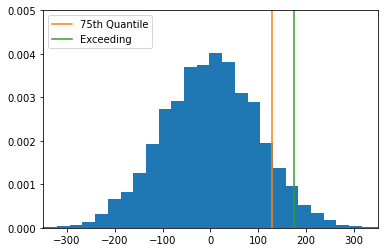

In [58]:
# Post-hoc metrics

from scipy.stats import norm

tau = 0.9

y_true = 100*np.random.randn(5000)
y_pred = 100*norm.ppf(tau)*np.ones(len(y_true))

print('CP = {}%'.format(100*sum(y_true < y_pred)/len(y_true)))

def exceeding(y_true, y_pred):
    return np.mean((y_true - y_pred)[y_true > y_pred])

def closeness(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

print('Closeness: {} MW'.format(closeness(y_true, y_pred)))
print('Exceeding: {} MW'.format(exceeding(y_true, y_pred)))

plt.hist(y_true, 30, density = True)
plt.plot([y_pred[0], y_pred[0]], [0.0, 3.0], label = "75th Quantile")
plt.plot([y_pred[0] + exceeding(y_true, y_pred), y_pred[0] + exceeding(y_true, y_pred)], [0.0, 3.0], label = "Exceeding")
plt.axis([-350.0, 350.0, 0.0, 0.005])
plt.legend()
plt.show()

In [22]:
rescue_model_set = {}
history = {}

for tau in PI_percentiles:
    print("Training model for Prediction interval: {:.0%}".format(tau))
    for fold_idx in range(num_cv_folds):
        print("Cross Validation fold #", fold_idx+1)
        
        # Split into training and validation dataset based on the validation masks of this CV fold
        input_train, output_train = input_trainval[~val_masks_all_folds[fold_idx]], output_trainval[~val_masks_all_folds[fold_idx]]
        input_val, output_val = input_trainval[val_masks_all_folds[fold_idx]], output_trainval[val_masks_all_folds[fold_idx]]
        
        # cast to 'float32'
        input_train = input_train.values.astype('float32')
        output_train = output_train.values.astype('float32')
        input_val = input_val.values.astype('float32')
        output_val = output_val.values.astype('float32')

        # Transoform into tensorflow Dataset type for training
        train_ds = tf.data.Dataset.from_tensor_slices((input_train, output_train)).shuffle(buffer_size= n_samples).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((input_val, output_val)).shuffle(buffer_size = n_samples).batch(batch_size)


        rescue_model_set[(tau, fold_idx)] = tf.keras.models.clone_model(rescue_model)
        rescue_model_set[(tau, fold_idx)].get_layer(index = 1).adapt(input_trainval.values) 
        rescue_model_set[(tau, fold_idx)].compile(loss = PinballLoss(tau = tau), 
                                                  metrics= [CoverageProbability(), 
                                                            AverageIntervalWidth()],
                                                  optimizer=optimizer_choice)
        
        history[(tau, fold_idx)]= rescue_model_set[(tau, fold_idx)].fit(train_ds, validation_data=val_ds, epochs=max_epochs,
                                                                        callbacks=[cb_early_stopping, get_cb_check_points_for_tau(model_directory, tau)])

Training model for Prediction interval: 25%
Cross Validation fold # 1
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 6s 2ms/step - loss: 153.6047 - CP: 0.2024 - AIW: 394.1121 - val_loss: 103.1991 - val_CP: 0.2057 - val_AIW: 612.0918
Epoch 2/20
2846/2846 [==============================] - 4s 1ms/step - loss: 105.2724 - CP: 0.2236 - AIW: 478.9767 - val_loss: 97.1871 - val_CP: 0.2237 - val_AIW: 602.2654
Epoch 3/20
2846/2846 [==============================] - 4s 1ms/step - loss: 100.8389 - CP: 0.2308 - AIW: 633.3272 - val_loss: 94.0414 - val_CP: 0.2312 - val_AIW: 730.6054
Epoch 4/20
2846/2846 [==============================] - 4s 1ms/step - loss: 97.5458 - CP: 0.2352 - AIW: 388.5971 - val_loss: 91.2709 - val_CP: 0.2354 - val_AIW: 849.7469
Epoch 5/20
2846/2846 [==============================] - 4s 1ms/step - loss: 94.8360 - CP: 0.2379 - AIW: 451.7395 - val_loss: 89.3310 - val_CP: 0.2379 - val_AIW: 585.4944
Epoch 6/20
2846/2846 [=========

2846/2846 [==============================] - 5s 2ms/step - loss: 150.7064 - CP: 0.2131 - AIW: 620.4937 - val_loss: 103.4476 - val_CP: 0.2155 - val_AIW: 602.5187
Epoch 2/20
2846/2846 [==============================] - 5s 2ms/step - loss: 104.9281 - CP: 0.2292 - AIW: 737.7612 - val_loss: 95.7673 - val_CP: 0.2306 - val_AIW: 478.3276
Epoch 3/20
2846/2846 [==============================] - 5s 2ms/step - loss: 100.1932 - CP: 0.2363 - AIW: 589.2971 - val_loss: 91.8860 - val_CP: 0.2366 - val_AIW: 188.6059
Epoch 4/20
2846/2846 [==============================] - 5s 2ms/step - loss: 96.7901 - CP: 0.2395 - AIW: 553.5908 - val_loss: 89.0670 - val_CP: 0.2397 - val_AIW: 406.9610
Epoch 5/20
2846/2846 [==============================] - 4s 2ms/step - loss: 94.2608 - CP: 0.2414 - AIW: 385.7917 - val_loss: 87.0653 - val_CP: 0.2414 - val_AIW: 272.2562
Epoch 6/20
2846/2846 [==============================] - 5s 2ms/step - loss: 92.5665 - CP: 0.2426 - AIW: 731.5873 - val_loss: 86.0036 - val_CP: 0.2426 - val_A

Epoch 4/20
2846/2846 [==============================] - 5s 2ms/step - loss: 96.1990 - CP: 0.2364 - AIW: 363.7761 - val_loss: 93.3242 - val_CP: 0.2362 - val_AIW: 688.8842
Epoch 5/20
2846/2846 [==============================] - 4s 2ms/step - loss: 93.8351 - CP: 0.2383 - AIW: 473.5051 - val_loss: 91.4663 - val_CP: 0.2383 - val_AIW: 635.1328
Epoch 6/20
2846/2846 [==============================] - 5s 2ms/step - loss: 92.2450 - CP: 0.2398 - AIW: 367.1526 - val_loss: 90.1810 - val_CP: 0.2398 - val_AIW: 708.0521
Epoch 7/20
2846/2846 [==============================] - 5s 2ms/step - loss: 91.3440 - CP: 0.2409 - AIW: 538.6072 - val_loss: 89.7423 - val_CP: 0.2409 - val_AIW: 404.2350
Epoch 8/20
2846/2846 [==============================] - 5s 2ms/step - loss: 90.8102 - CP: 0.2417 - AIW: 512.9781 - val_loss: 89.0549 - val_CP: 0.2418 - val_AIW: 22.2735
Epoch 9/20
2846/2846 [==============================] - 5s 2ms/step - loss: 90.4557 - CP: 0.2425 - AIW: 451.2506 - val_loss: 88.6026 - val_CP: 0.2425 -

Epoch 5/20
2846/2846 [==============================] - 4s 1ms/step - loss: 90.9582 - CP: 0.2361 - AIW: 509.1984 - val_loss: 113.0309 - val_CP: 0.2366 - val_AIW: 461.5563
Epoch 6/20
2846/2846 [==============================] - 4s 1ms/step - loss: 89.3248 - CP: 0.2383 - AIW: 601.8123 - val_loss: 111.7279 - val_CP: 0.2386 - val_AIW: 44.3197
Epoch 7/20
2846/2846 [==============================] - 4s 1ms/step - loss: 88.3880 - CP: 0.2399 - AIW: 417.1961 - val_loss: 111.0259 - val_CP: 0.2401 - val_AIW: 97.2453
Epoch 8/20
2846/2846 [==============================] - 4s 2ms/step - loss: 87.8483 - CP: 0.2410 - AIW: 784.6554 - val_loss: 110.7419 - val_CP: 0.2411 - val_AIW: 748.3343
Epoch 00008: early stopping
Cross Validation fold # 8
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 154.2362 - CP: 0.2153 - AIW: 478.7070 - val_loss: 109.9017 - val_CP: 0.2176 - val_AIW: 498.6437
Epoch 2/20
2846/2846 [=========================

Epoch 8/20
2846/2846 [==============================] - 4s 2ms/step - loss: 90.6630 - CP: 0.2396 - AIW: 487.5605 - val_loss: 87.7867 - val_CP: 0.2398 - val_AIW: 119.0056
Epoch 9/20
2846/2846 [==============================] - 4s 1ms/step - loss: 90.2960 - CP: 0.2406 - AIW: 422.9734 - val_loss: 87.4836 - val_CP: 0.2408 - val_AIW: 44.6800
Epoch 10/20
2846/2846 [==============================] - 4s 2ms/step - loss: 90.0217 - CP: 0.2415 - AIW: 482.9543 - val_loss: 87.1570 - val_CP: 0.2418 - val_AIW: 731.3555
Epoch 00010: early stopping
Cross Validation fold # 10
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 155.6959 - CP: 0.1996 - AIW: 511.8028 - val_loss: 108.6389 - val_CP: 0.2020 - val_AIW: 466.6218
Epoch 2/20
2846/2846 [==============================] - 4s 1ms/step - loss: 105.4917 - CP: 0.2203 - AIW: 350.9661 - val_loss: 100.5207 - val_CP: 0.2219 - val_AIW: 757.6611
Epoch 3/20
2846/2846 [========================

2846/2846 [==============================] - 4s 1ms/step - loss: 113.5423 - CP: 0.5088 - AIW: 783.4847 - val_loss: 109.5144 - val_CP: 0.5089 - val_AIW: 1061.4789
Epoch 10/20
2846/2846 [==============================] - 4s 2ms/step - loss: 112.8250 - CP: 0.5089 - AIW: 680.7055 - val_loss: 108.7328 - val_CP: 0.5088 - val_AIW: 786.2527
Epoch 11/20
2846/2846 [==============================] - 4s 1ms/step - loss: 111.9690 - CP: 0.5086 - AIW: 856.2208 - val_loss: 107.9671 - val_CP: 0.5086 - val_AIW: 418.5281
Epoch 12/20
2846/2846 [==============================] - 4s 2ms/step - loss: 111.2170 - CP: 0.5083 - AIW: 724.7101 - val_loss: 107.6413 - val_CP: 0.5084 - val_AIW: 329.9362
Epoch 13/20
2846/2846 [==============================] - 4s 1ms/step - loss: 110.5712 - CP: 0.5080 - AIW: 674.1744 - val_loss: 107.0953 - val_CP: 0.5080 - val_AIW: 937.0617
Epoch 14/20
2846/2846 [==============================] - 4s 2ms/step - loss: 110.1622 - CP: 0.5077 - AIW: 683.6201 - val_loss: 106.6965 - val_CP: 

2846/2846 [==============================] - 4s 1ms/step - loss: 121.1818 - CP: 0.5046 - AIW: 740.5797 - val_loss: 113.6581 - val_CP: 0.5051 - val_AIW: 346.9756
Epoch 6/20
2846/2846 [==============================] - 4s 2ms/step - loss: 118.7513 - CP: 0.5077 - AIW: 730.2134 - val_loss: 111.7647 - val_CP: 0.5080 - val_AIW: 924.8081
Epoch 7/20
2846/2846 [==============================] - 4s 1ms/step - loss: 117.1549 - CP: 0.5093 - AIW: 813.5381 - val_loss: 110.6069 - val_CP: 0.5096 - val_AIW: 830.9932
Epoch 8/20
2846/2846 [==============================] - 4s 1ms/step - loss: 116.0276 - CP: 0.5104 - AIW: 703.5283 - val_loss: 109.5005 - val_CP: 0.5106 - val_AIW: 933.2310
Epoch 9/20
2846/2846 [==============================] - 5s 2ms/step - loss: 115.1471 - CP: 0.5109 - AIW: 596.5677 - val_loss: 108.7079 - val_CP: 0.5109 - val_AIW: 812.8713
Epoch 10/20
2846/2846 [==============================] - 4s 2ms/step - loss: 114.4687 - CP: 0.5109 - AIW: 737.8391 - val_loss: 108.0911 - val_CP: 0.510

2846/2846 [==============================] - 4s 1ms/step - loss: 109.3332 - CP: 0.5048 - AIW: 608.6411 - val_loss: 116.0732 - val_CP: 0.5047 - val_AIW: 881.6419
Epoch 14/20
2846/2846 [==============================] - 4s 2ms/step - loss: 109.0397 - CP: 0.5045 - AIW: 516.9385 - val_loss: 115.9255 - val_CP: 0.5045 - val_AIW: 769.4810
Epoch 00014: early stopping
Cross Validation fold # 5
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 209.3527 - CP: 0.3964 - AIW: 583.1912 - val_loss: 134.4442 - val_CP: 0.4046 - val_AIW: 1147.3412
Epoch 2/20
2846/2846 [==============================] - 4s 2ms/step - loss: 128.9614 - CP: 0.4475 - AIW: 607.1119 - val_loss: 123.6355 - val_CP: 0.4497 - val_AIW: 485.2080
Epoch 3/20
2846/2846 [==============================] - 4s 1ms/step - loss: 122.0822 - CP: 0.4648 - AIW: 479.6678 - val_loss: 118.2368 - val_CP: 0.4649 - val_AIW: 581.5001
Epoch 4/20
2846/2846 [============================

Epoch 8/20
2846/2846 [==============================] - 4s 2ms/step - loss: 111.9986 - CP: 0.4889 - AIW: 805.3855 - val_loss: 105.2749 - val_CP: 0.4891 - val_AIW: 752.9979
Epoch 00008: early stopping
Cross Validation fold # 7
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 203.7957 - CP: 0.4236 - AIW: 596.5927 - val_loss: 163.2780 - val_CP: 0.4336 - val_AIW: 905.0540
Epoch 2/20
2846/2846 [==============================] - 4s 2ms/step - loss: 137.0895 - CP: 0.4743 - AIW: 670.6069 - val_loss: 154.1427 - val_CP: 0.4766 - val_AIW: 455.5803
Epoch 3/20
2846/2846 [==============================] - 4s 1ms/step - loss: 128.6055 - CP: 0.4915 - AIW: 811.6344 - val_loss: 146.6885 - val_CP: 0.4925 - val_AIW: 834.6243
Epoch 4/20
2846/2846 [==============================] - 4s 1ms/step - loss: 122.3970 - CP: 0.5008 - AIW: 728.7328 - val_loss: 141.6707 - val_CP: 0.5016 - val_AIW: 1167.9874
Epoch 5/20
2846/2846 [==================

2846/2846 [==============================] - 4s 1ms/step - loss: 108.2886 - CP: 0.5123 - AIW: 709.6859 - val_loss: 126.8889 - val_CP: 0.5122 - val_AIW: 604.8464
Cross Validation fold # 8
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 217.1491 - CP: 0.3826 - AIW: 640.5147 - val_loss: 135.1873 - val_CP: 0.3919 - val_AIW: 860.3018
Epoch 2/20
2846/2846 [==============================] - 4s 1ms/step - loss: 129.4999 - CP: 0.4388 - AIW: 615.2299 - val_loss: 127.0692 - val_CP: 0.4405 - val_AIW: 604.9605
Epoch 3/20
2846/2846 [==============================] - 4s 2ms/step - loss: 122.9782 - CP: 0.4581 - AIW: 552.9721 - val_loss: 122.2768 - val_CP: 0.4587 - val_AIW: 1049.5657
Epoch 4/20
2846/2846 [==============================] - 4s 1ms/step - loss: 118.6612 - CP: 0.4685 - AIW: 708.5178 - val_loss: 118.5027 - val_CP: 0.4686 - val_AIW: 912.0225
Epoch 5/20
2846/2846 [==============================] - 4s 1ms/step - loss: 115

Epoch 11/20
2846/2846 [==============================] - 3s 1ms/step - loss: 111.2227 - CP: 0.5025 - AIW: 780.8253 - val_loss: 109.3177 - val_CP: 0.5028 - val_AIW: 647.7888
Epoch 00011: early stopping
Cross Validation fold # 10
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 207.5870 - CP: 0.4258 - AIW: 850.7510 - val_loss: 137.9764 - val_CP: 0.4358 - val_AIW: 595.7030
Epoch 2/20
2846/2846 [==============================] - 4s 1ms/step - loss: 139.6718 - CP: 0.4756 - AIW: 745.0242 - val_loss: 129.6540 - val_CP: 0.4787 - val_AIW: 714.4689
Epoch 3/20
2846/2846 [==============================] - 4s 2ms/step - loss: 131.5278 - CP: 0.4921 - AIW: 747.5900 - val_loss: 121.9216 - val_CP: 0.4931 - val_AIW: 641.7030
Epoch 4/20
2846/2846 [==============================] - 4s 1ms/step - loss: 124.5567 - CP: 0.5002 - AIW: 849.7504 - val_loss: 116.7183 - val_CP: 0.5012 - val_AIW: 805.9339
Epoch 5/20
2846/2846 [=================

Epoch 10/20
2846/2846 [==============================] - 4s 1ms/step - loss: 91.6739 - CP: 0.7358 - AIW: 1039.7198 - val_loss: 88.6491 - val_CP: 0.7360 - val_AIW: 650.2370
Epoch 11/20
2846/2846 [==============================] - 4s 1ms/step - loss: 91.2760 - CP: 0.7376 - AIW: 1066.2299 - val_loss: 88.3752 - val_CP: 0.7377 - val_AIW: 773.6028
Epoch 12/20
2846/2846 [==============================] - 3s 1ms/step - loss: 90.8903 - CP: 0.7390 - AIW: 665.1747 - val_loss: 88.4727 - val_CP: 0.7391 - val_AIW: 352.6274
Epoch 00012: early stopping
Cross Validation fold # 2
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 234.2667 - CP: 0.5621 - AIW: 1043.1591 - val_loss: 114.3426 - val_CP: 0.5819 - val_AIW: 645.1871
Epoch 2/20
2846/2846 [==============================] - 4s 1ms/step - loss: 112.2152 - CP: 0.6594 - AIW: 1035.3600 - val_loss: 105.5750 - val_CP: 0.6644 - val_AIW: 704.0905
Epoch 3/20
2846/2846 [==================

Epoch 9/20
2846/2846 [==============================] - 4s 1ms/step - loss: 92.1525 - CP: 0.7384 - AIW: 961.2642 - val_loss: 87.8407 - val_CP: 0.7388 - val_AIW: 901.1884
Epoch 10/20
2846/2846 [==============================] - 4s 2ms/step - loss: 91.7833 - CP: 0.7404 - AIW: 740.8395 - val_loss: 87.5773 - val_CP: 0.7407 - val_AIW: 900.4214
Epoch 11/20
2846/2846 [==============================] - 4s 1ms/step - loss: 91.4285 - CP: 0.7419 - AIW: 874.4234 - val_loss: 87.3831 - val_CP: 0.7422 - val_AIW: 492.8995
Epoch 00011: early stopping
Cross Validation fold # 4
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 230.5297 - CP: 0.5750 - AIW: 896.0011 - val_loss: 122.8245 - val_CP: 0.5920 - val_AIW: 868.2852
Epoch 2/20
2846/2846 [==============================] - 4s 2ms/step - loss: 110.8343 - CP: 0.6641 - AIW: 818.5782 - val_loss: 114.6579 - val_CP: 0.6684 - val_AIW: 601.5551
Epoch 3/20
2846/2846 [=======================

2846/2846 [==============================] - 4s 2ms/step - loss: 97.2875 - CP: 0.7158 - AIW: 967.5278 - val_loss: 94.1712 - val_CP: 0.7165 - val_AIW: 928.5856
Epoch 6/20
2846/2846 [==============================] - 4s 1ms/step - loss: 94.9832 - CP: 0.7232 - AIW: 883.6080 - val_loss: 92.5208 - val_CP: 0.7237 - val_AIW: 910.8889
Epoch 7/20
2846/2846 [==============================] - 4s 1ms/step - loss: 93.8180 - CP: 0.7285 - AIW: 892.9883 - val_loss: 91.4757 - val_CP: 0.7288 - val_AIW: 1249.2465
Epoch 8/20
2846/2846 [==============================] - 4s 2ms/step - loss: 93.0478 - CP: 0.7322 - AIW: 903.4510 - val_loss: 91.1004 - val_CP: 0.7325 - val_AIW: 590.8210
Epoch 9/20
2846/2846 [==============================] - 4s 1ms/step - loss: 92.4839 - CP: 0.7351 - AIW: 985.5445 - val_loss: 90.7375 - val_CP: 0.7351 - val_AIW: 802.9632
Epoch 00009: early stopping
Cross Validation fold # 6
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2m

Epoch 8/20
2846/2846 [==============================] - 4s 1ms/step - loss: 91.1845 - CP: 0.7327 - AIW: 900.0473 - val_loss: 102.5131 - val_CP: 0.7330 - val_AIW: 972.1740
Epoch 9/20
2846/2846 [==============================] - 4s 1ms/step - loss: 90.7315 - CP: 0.7355 - AIW: 973.7809 - val_loss: 102.2253 - val_CP: 0.7357 - val_AIW: 607.7297
Epoch 10/20
2846/2846 [==============================] - 4s 2ms/step - loss: 90.3431 - CP: 0.7377 - AIW: 894.4188 - val_loss: 101.9229 - val_CP: 0.7377 - val_AIW: 738.9774
Epoch 00010: early stopping
Cross Validation fold # 8
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 235.9584 - CP: 0.5599 - AIW: 1089.9310 - val_loss: 119.0910 - val_CP: 0.5768 - val_AIW: 993.9103
Epoch 2/20
2846/2846 [==============================] - 4s 1ms/step - loss: 111.7012 - CP: 0.6561 - AIW: 892.8561 - val_loss: 109.6123 - val_CP: 0.6599 - val_AIW: 764.5602
Epoch 3/20
2846/2846 [====================

2846/2846 [==============================] - 4s 2ms/step - loss: 92.5409 - CP: 0.7309 - AIW: 836.6107 - val_loss: 92.0659 - val_CP: 0.7313 - val_AIW: 1163.6884
Epoch 9/20
2846/2846 [==============================] - 4s 1ms/step - loss: 92.0027 - CP: 0.7338 - AIW: 925.8969 - val_loss: 91.1680 - val_CP: 0.7341 - val_AIW: 936.9453
Epoch 10/20
2846/2846 [==============================] - 4s 1ms/step - loss: 91.5655 - CP: 0.7361 - AIW: 928.2927 - val_loss: 90.8755 - val_CP: 0.7362 - val_AIW: 732.8190
Epoch 11/20
2846/2846 [==============================] - 4s 2ms/step - loss: 91.2350 - CP: 0.7377 - AIW: 773.3521 - val_loss: 90.2741 - val_CP: 0.7381 - val_AIW: 618.8325
Epoch 00011: early stopping
Cross Validation fold # 10
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2846/2846 [==============================] - 5s 2ms/step - loss: 268.6285 - CP: 0.5016 - AIW: 740.7344 - val_loss: 120.4606 - val_CP: 0.5222 - val_AIW: 603.8658
Epoch 2/20
2846/2846 [==============================] - 

In [23]:
history[(tau, fold_idx)].history

{'loss': [268.63901115157597,
  112.59626165070021,
  105.08822289013342,
  100.38497996820891,
  96.86624763174935,
  94.39665016608458,
  92.87329145077176,
  91.98931416157633,
  91.40361621983949,
  90.94949702208275,
  90.6558091090308],
 'CP': [0.5016142138668658,
  0.6224154880858878,
  0.662883899726005,
  0.683131409631013,
  0.6959879468985853,
  0.7047895194399916,
  0.7113435580713172,
  0.7163684492988774,
  0.7202397212357836,
  0.7232710178680704,
  0.7258939030714942],
 'AIW': [740.7344,
  827.27344,
  742.27075,
  625.84015,
  806.50555,
  1019.2683,
  799.9213,
  946.45044,
  812.1769,
  918.4895,
  907.81287],
 'val_loss': [120.46055294963463,
  106.18776818404814,
  100.51974040852737,
  96.12511682359954,
  93.359019065881,
  92.10678513343402,
  90.62674128294744,
  89.97499362452173,
  89.50331668071566,
  89.51131288787168,
  89.09961629440356],
 'val_CP': [0.5221821416217819,
  0.6283144734891535,
  0.665352242591952,
  0.6846839946632406,
  0.6969669417403765,

In [28]:
# Visualizing cross-validation performance and generalizability of the model
# reassemble the best performing model's loss
train_losses = pd.DataFrame(None, index = PI_percentiles)
val_losses = train_losses.copy()
train_cp = train_losses.copy()
val_cp = train_losses.copy()

for tau in PI_percentiles:
    for fold_idx in range(num_cv_folds):
        train_losses.loc[tau, fold_idx] = history[(tau, fold_idx)].history['loss'][-1]
        train_cp.loc[tau,fold_idx] = history[(tau, fold_idx)].history['CP'][-1]
        val_losses.loc[tau, fold_idx] = history[(tau, fold_idx)].history['val_loss'][-1]
        val_cp.loc[tau,fold_idx] = history[(tau, fold_idx)].history['val_CP'][-1]

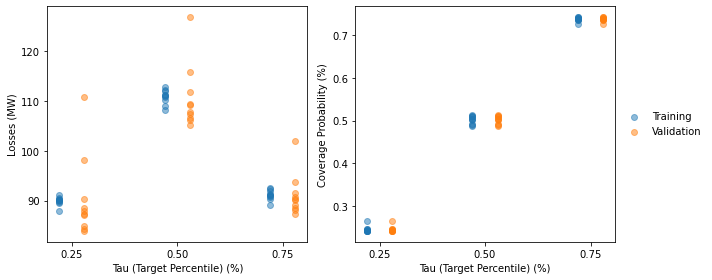

In [29]:
# Visualization of the training process

fig, axarr = plt.subplots(1,2, sharex = True)
train_x_pos =np.expand_dims(np.array(PI_percentiles),1)*np.ones((1,10)) - 0.03
val_x_pos = np.expand_dims(np.array(PI_percentiles),1)*np.ones((1,10)) + 0.03

axarr[0].scatter(train_x_pos.ravel(), train_losses.values.ravel(),label = 'Training', alpha = 0.5)
axarr[0].scatter(val_x_pos.ravel(), val_losses.values.ravel(), label = 'Validation',alpha = 0.5)
axarr[0].set_xticks(PI_percentiles)
axarr[0].set_xlabel('Tau (Target Percentile) (%)')
axarr[0].set_ylabel('Losses (MW)')

axarr[1].scatter(train_x_pos.ravel(), train_cp.values.ravel(), label = 'Training' ,alpha = 0.5)
axarr[1].scatter(val_x_pos.ravel(), val_cp.values.ravel(), label = 'Validation',alpha = 0.5)
axarr[1].set_xticks(PI_percentiles)
axarr[1].set_xlabel('Tau (Target Percentile) (%)')
axarr[1].set_ylabel('Coverage Probability (%)')

axarr[1].legend(loc = 'center left', bbox_to_anchor = [1,0.5], frameon = False)
fig.set_size_inches(10,4)
fig.tight_layout()
fig.savefig('cross_validation_and_generalizability.png', bbox_inches = 'tight')

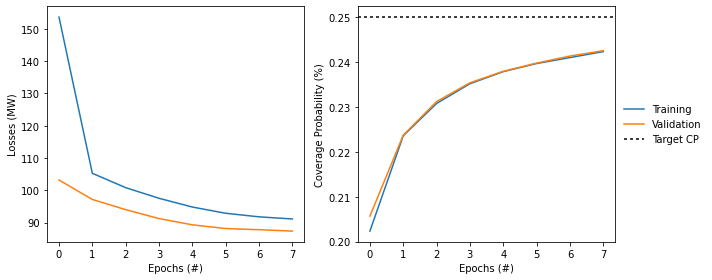

In [30]:
fig, axarr = plt.subplots(1,2, sharex = True)
history_eg = history[(0.25,0)].history

axarr[0].plot(history_eg['loss'],label = 'Training')
axarr[0].plot(history_eg['val_loss'], label = 'Validation')

axarr[0].set_xlabel('Epochs (#)')
axarr[0].set_ylabel('Losses (MW)')

axarr[1].plot(history_eg['CP'], label = 'Training')
axarr[1].plot(history_eg['val_CP'], label = 'Validation')
axarr[1].axhline(0.25, label = 'Target CP', dashes = [2,2], color = 'k')
axarr[1].set_xlabel('Epochs (#)')
axarr[1].set_ylabel('Coverage Probability (%)')

axarr[1].legend(loc = 'center left', bbox_to_anchor = [1,0.5], frameon = False)
fig.set_size_inches(10,4)
fig.tight_layout()
fig.savefig('training_history.png', bbox_inches = 'tight')

In [31]:
# Visualizing forecast uncertainty over different times of the day
low_band_forecast = rescue_model_set[(0.25,0)].predict(input_trainval.values)
median_forecast = rescue_model_set[(0.5,0)].predict(input_trainval.values)
high_band_forecast = rescue_model_set[(0.75,0)].predict(input_trainval.values)

prediction_timeseries['low'] = np.squeeze(low_band_forecast)
prediction_timeseries['median'] = np.squeeze(median_forecast)
prediction_timeseries['high'] = np.squeeze(high_band_forecast)

NameError: name 'prediction_timeseries' is not defined

In [ ]:
prediction_timeseries = pd.DataFrame(index = pd.to_datetime(datetimes_trainval.loc['T+1'], infer_datetime_format=True))

In [ ]:
diurnal_trend = prediction_timeseries.groupby(prediction_timeseries.index.hour).mean()

diurnal_trend.plot()

In [ ]:
diurnal_trend_debiased = diurnal_trend - np.expand_dims(diurnal_trend['median'].values, axis=1)
diurnal_trend_debiased.plot()

In [ ]:
datetimes_trainval

# 3. Deploying the model

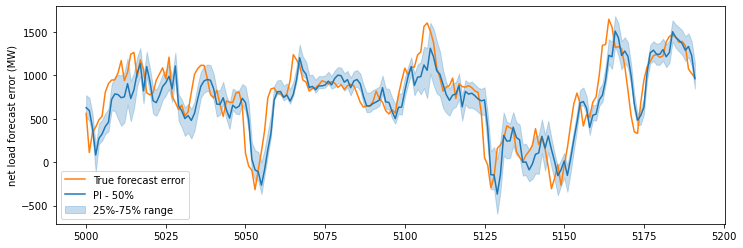

In [10]:
example_range = np.arange(5000,5192)
input_val_eg = input_val[example_range]
output_val_eg = output_val[example_range]

# confirm the PI percentiles are symmetrical
for PI in PI_percentiles:
    assert 1-PI in PI_percentiles, "Not all PI intervals are constructed symmetrically!"


fig,ax = plt.subplots()
ax.plot(example_range, output_val_eg, color = 'C1', label = 'True forecast error')

# plot median forecast if it is being produced
if 0.5 in PI_percentiles:
    ax.plot(example_range, rescue_model_set[0.5].predict(input_val_eg), color = 'C0', label = 'PI - 50%')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)),
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)),
                        color = 'C0', alpha = PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))

ax.set_ylabel("net load forecast error (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

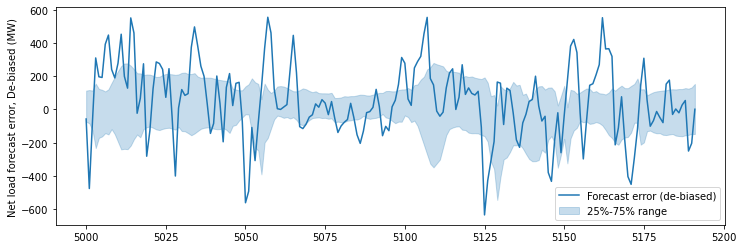

In [10]:
fig,ax = plt.subplots()
inherent_bias_eg = np.squeeze(rescue_model_set[0.5].predict(input_val[example_range]))

ax.plot(example_range, np.squeeze(output_val_eg) - inherent_bias_eg, label = 'Forecast error (de-biased)')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)) - inherent_bias_eg,
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)) - inherent_bias_eg,
                        color = 'C0', alpha =PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))


ax.set_ylabel("Net load forecast error, De-biased (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

Choose an optimizer and loss function for training: 

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [7]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# test_loss = tf.keras.metrics.Mean(name='test_loss')

Use `tf.GradientTape` to train the model:

Test the model:

In [9]:
@tf.function
def train_step(inputs, outputs, model, loss_fn):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(inputs, training=True)
        loss = loss_fn(outputs, predictions)
    gradients = tape.gradient(loss, rescue.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rescue.trainable_variables))

    train_loss(loss)
    #train_accuracy(outputs, predictions)


@tf.function
def test_step(inputs, outputs, model, loss_fn):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = rescue(inputs, training=False)
    t_loss = loss_object(outputs, predictions)

    test_loss(t_loss)
    #test_accuracy(outputs, predictions)

In [10]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   #train_accuracy.reset_states()
#   test_loss.reset_states()
#   #test_accuracy.reset_states()

#   for inputs, outputs in train_ds:
#     train_step(inputs, outputs)

#   for test_inputs, test_outputs in test_ds:
#     test_step(test_inputs, test_outputs)

#   print(
#     f'Epoch {epoch + 1}, '
#     f'Loss: {train_loss.result()}, '
#     #f'Accuracy: {train_accuracy.result() * 100}, '
#     f'Test Loss: {test_loss.result()}, '
#     #f'Test Accuracy: {test_accuracy.result() * 100}'
#   )

Epoch 1, Loss: nan, Test Loss: nan, 
Epoch 2, Loss: nan, Test Loss: nan, 
Epoch 3, Loss: nan, Test Loss: nan, 
Epoch 4, Loss: nan, Test Loss: nan, 
Epoch 5, Loss: nan, Test Loss: nan, 
